In [1]:
# remember to scale problem

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details
Stall Torque =  153.4


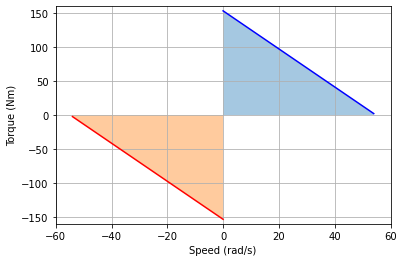

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_Aug25.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body':5670/1000,
           'UL': 867/1000,
           'UR': 867/1000,
           'footL': 180/1000,
           'footR': 180/1000}

lengths_ = {'body': 24/100,
           'UL': 15.0/100,
           'UR': 15.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
                
        tau_value.update({(side): \
        BW*(m.tau_torque[n,side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('Stall Torque = ', 153.4)

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

<a id='time_step'></a>

In [3]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Walk"}

test = tests[8]

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Walk":
    N = 50
    TT = 0.5# 2Hz but only half a gait due to symmetry
    V_avg = 2.2
    x_final = 1.0 # for display
else:
    N = 50
    TT = 0.5
    
test

'Periodic_Walk'

In [4]:
total_mass

7.763999999999999

In [5]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [6]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [7]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet)
for n in range(1,N+1):
    m.foot_position[n,'Y','footL'].setlb(0.0)
    m.foot_position[n,'Y','footR'].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 10.0,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,None)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)

In [8]:
'''Torque Speed - Speed Torque Curve'''

max_torque = 38.0
max_rotational_speed = 46.0

m.tau_torque = Var(m.N, m.sides,bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides,bounds = (-max_rotational_speed,max_rotational_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side):
    return m.tau_torque[n,side] <= m.tau_velocity[n,side]*(-2.8) + 153.4
m.constant_power_right_constraint = Constraint(m.N, m.sides,rule = def_constant_power_right)

def def_constant_power_left(m,n,side):
    return m.tau_torque[n,side] >= m.tau_velocity[n,side]*(-2.8) - 153.4
m.constant_power_left_constraint = Constraint(m.N, m.sides,rule = def_constant_power_left)

In [9]:
# m.Fp = Var(m.N, m.sides, bounds = (-total_mass*9.81,total_mass*9.81))

# Fo = 5*(total_mass*9.81) = 383N

# given the torque speed curve, what radius should the pinion be such that Fo = 383N?
Tau_stall = 153.4 # using the equation: y_p = -2.8*x_p + 153.4
pinion_radius = 0.4 # T = F*d
Fo = Tau_stall/pinion_radius # stall force
# max_power = max_torque*max_rotational_speed # Tau_max*w_max    https://www.clear.rice.edu/elec201/Book/motors.html 
max_power = (153.4*54.8)/4
Fp_max = max_torque/pinion_radius
m.Fp = Var(m.N, m.sides,bounds = (-Fp_max,Fp_max))


max_translational_speed = max_rotational_speed*pinion_radius 
m.Fp_velocity = Var(m.N, m.sides,bounds = (-max_translational_speed,max_translational_speed))


lamb_Fp_velocity = {}
lamb_Fp_velocity.update({('left'): sym.lambdify(sym_list,dq[5],modules = [func_map])})
lamb_Fp_velocity.update({('right'): sym.lambdify(sym_list,dq[6],modules = [func_map])})


def def_Fp_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.Fp_velocity[n,side] == lamb_Fp_velocity[side](*var_list)   
m.Fp_velocity_constraint = Constraint(m.N, m.sides, rule = def_Fp_velocity)

# assume straight line
def def_Fp_right(m,n,side):
    return m.Fp[n,side] <= Fo*(1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_right_constraint = Constraint(m.N, m.sides,rule = def_Fp_right)

def def_Fp_left(m,n,side):
    return m.Fp[n,side] >= Fo*(-1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_left_constraint = Constraint(m.N, m.sides,rule = def_Fp_left)

In [10]:
# Fo
# max_power

<a id='constraints'></a>

In [11]:
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    # Average velocities
    if test == "Periodic_Walk": 
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
    else: pass
    
    # Equate states
    
    if test == "Periodic_Walk":
        
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'x_body': # or dof_i == 'theta_UL' or dof_i == 'theta_UR':
                return Constraint.Skip
            else:
                return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)

        def def_equate_angle_states(m,n):
            return m.q[N,'theta_UL'] == m.q[N,'theta_UR']
        m.def_equate_angle_states_constraint = Constraint(m.N,rule = def_equate_angle_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
        
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [12]:
''' Use this code for tests '''

# BOUND VALUES
for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/3))
    m.q[n,'theta_body'].setlb(np.pi*(-1/3))
    
    # 0.15 - 0.5 = 0.35
    
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    m.q[n,'theta_UL'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UL'].setub(np.pi*(1/3))
    m.q[n,'theta_UR'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UR'].setub(np.pi*(1/3))
    
    for foot in feet:
        m.GRF_y[n,foot].setlb(0.0)
        m.GRF_y[n,foot].setub(10*total_mass*m.g.value)
        
        for sgn in signs:
            m.GRF_x[n,sgn,foot].setlb(0.0)
            m.GRF_x[n,sgn,foot].setub(10*total_mass*m.g.value)  
    
    if test == "Periodic_Walk":
        m.q[n,'y_body'].setub(1.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        
        if test == "Drop_Hop_Test" or "Periodic_Hop":
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]
            
        else:
            [m.tau_torque[n,side].fix(0.0) for side in sides]
            [m.Fp[n,side].fix(0.0) for side in sides]
        

    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Walk":
            pass
        else:
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]

<a id='initial_conditions'></a>

In [13]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(-2/9))
    m.q[1,'theta_UR'].fix(np.pi*(2/9))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(1/6))
    m.q[N,'theta_UR'].setlb(np.pi*(1/6))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Walk":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    
else: pass

<a id='cost_function'></a>

In [14]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
            for side in sides:
                actuation_sum += (m.tau_torque[n,side])**2 + (m.Fp[n,side])**2
                
                if test == "Periodic_Walk":
                    transport_sum += ((m.tau_torque[n,side])**2 + (m.Fp[n,side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
                    
    if test == "Periodic_Walk":
        return row*pen_sum + actuation_sum #+ transport_sum #+tau_sum
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [15]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [16]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    12548
Number of nonzeros in inequality constraint Jacobian.:     2086
Number of nonzeros in Lagrangian Hessian.............:     6714

Total number of variables............................:     2742
                     variables with only lower bounds:      400
                variables with lower and upper bounds:     1393
                     variables with only upp

  89r 1.9836196e+07 5.21e-02 2.48e+01  -3.8 8.78e+01  -3.9 2.08e-04 3.48e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.9836215e+07 4.16e-02 1.91e+01  -3.8 1.52e+01  -3.4 2.56e-01 2.02e-01h  1
  91r 1.9833508e+07 2.19e-01 1.08e+01  -3.8 6.48e+00  -3.0 1.35e-01 1.00e+00h  1
  92r 1.9832528e+07 2.10e-01 1.04e+01  -3.8 1.81e+01  -3.5 1.38e-01 4.92e-02h  1
  93r 1.9836010e+07 2.08e-01 9.34e+00  -3.8 6.12e+01  -4.0 2.67e-02 4.76e-02f  1
  94r 1.9836654e+07 1.97e-01 9.87e+00  -3.8 1.75e+01  -3.5 5.16e-01 6.66e-02h  1
  95r 1.9837422e+07 1.96e-01 2.25e+01  -3.8 5.74e+01  -4.0 5.49e-01 7.24e-03h  1
  96r 1.9838831e+07 1.80e-01 1.89e+01  -3.8 5.48e+01  -3.6 2.25e-01 7.74e-02h  1
  97r 1.9869748e+07 1.92e-02 6.21e+00  -3.8 9.14e+01  -4.1 1.08e-01 4.07e-01f  1
  98r 1.9873950e+07 1.66e-02 3.10e+00  -3.8 3.27e+00  -2.7 1.22e-01 4.61e-01h  1
  99r 1.9872552e+07 1.66e-02 2.48e+00  -3.8 1.01e+01  -3.2 2.60e-01 1.96e-01h  1
iter    objective    inf_pr 

 227r 2.0497219e+07 5.74e-02 3.72e+01  -3.8 8.09e+00  -0.2 1.15e-02 1.43e-06h  2
 228r 2.0497433e+07 5.75e-02 3.65e+01  -3.8 7.44e-01  -0.6 2.73e-02 2.23e-01h  1
 229r 2.0497395e+07 5.74e-02 6.18e+01  -3.8 7.25e-01  -1.1 1.00e+00 4.75e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 2.0500708e+07 5.76e-02 2.68e+01  -3.8 2.11e+00  -1.6 2.89e-01 1.00e+00f  1
 231r 2.0503158e+07 5.78e-02 2.85e+01  -3.8 5.33e+00  -2.1 1.00e+00 1.69e-01f  1
 232r 2.0503030e+07 5.78e-02 2.26e+01  -3.8 1.12e+01  -2.6 3.89e-01 4.90e-02f  1
 233r 2.0458418e+07 5.75e-02 1.35e+01  -3.8 1.55e+01  -3.0 4.01e-02 2.37e-01f  1
 234r 2.0337582e+07 5.71e-02 1.35e+01  -3.8 2.86e+01  -3.5 1.11e-01 2.95e-01f  1
 235r 2.0299599e+07 5.69e-02 1.07e+01  -3.8 2.81e+02  -4.0 9.26e-02 5.61e-02f  1
 236r 2.0289372e+07 5.69e-02 9.06e+00  -3.8 5.05e+01  -3.6 4.94e-02 2.42e-02f  1
 237r 2.0263304e+07 5.69e-02 8.13e+00  -3.8 1.42e+01  -3.1 9.52e-02 9.35e-02f  1
 238r 2.0157395e+07 5.67e-02

 364r 1.9713953e+07 5.77e-02 1.14e+01  -3.8 3.31e+01  -3.2 2.98e-01 2.30e-01f  1
 365r 1.9685600e+07 5.74e-02 4.38e+00  -3.8 9.03e+01  -3.7 1.41e-01 2.12e-01f  1
 366r 1.9662027e+07 5.72e-02 9.14e+00  -3.8 2.59e+01  -3.3 2.67e-01 4.21e-01f  1
 367r 1.9662341e+07 5.72e-02 4.51e+01  -3.8 1.53e+04  -3.7 5.06e-03 8.03e-05f  1
 368r 1.9631694e+07 5.70e-02 6.93e+00  -3.8 4.12e+01  -3.3 6.99e-01 1.00e+00f  1
 369r 1.9634833e+07 5.68e-02 5.39e+00  -3.8 2.62e+01  -2.9 1.00e+00 8.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 1.9638698e+07 5.66e-02 1.13e+00  -3.8 1.13e+01  -2.5 1.00e+00 1.00e+00f  1
 371r 1.9641719e+07 5.65e-02 2.40e+01  -3.8 4.06e+01  -2.9 1.86e-02 1.94e-01f  1
 372r 1.9683560e+07 5.79e-02 2.16e+01  -3.8 5.99e+01  -2.5 1.39e-01 1.48e-01f  1
 373r 1.9699062e+07 5.84e-02 1.17e+01  -3.8 1.21e+01  -2.1 3.13e-01 1.75e-01f  1
 374r 1.9731674e+07 5.93e-02 6.38e+00  -3.8 3.11e+00  -1.7 8.94e-01 1.00e+00f  1
 375r 1.9770337e+07 6.03e-02

 457r 1.9781531e+07 4.89e-02 1.05e+02  -3.8 1.67e+01  -2.4 1.82e-01 6.60e-01f  1
 458r 1.9749037e+07 4.81e-02 1.81e+02  -3.8 9.59e+00  -2.9 2.24e-01 1.00e+00f  1
 459r 1.9718133e+07 4.81e-02 1.52e+02  -3.8 9.04e+00  -3.4 2.95e-03 3.39e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r 1.9741827e+07 4.87e-02 1.45e+02  -3.8 1.20e+01  -2.1 1.16e-01 1.77e-01f  1
 461r 1.9759492e+07 4.92e-02 8.72e+01  -3.8 3.32e+00  -1.6 3.50e-01 2.80e-01f  1
 462r 1.9758169e+07 4.94e-02 7.02e+01  -3.8 1.89e+01  -2.1 9.38e-02 5.02e-02f  1
 463r 1.9758323e+07 4.97e-02 5.68e+01  -3.8 4.22e+00  -1.7 2.05e-01 1.68e-01f  1
 464r 1.9755886e+07 5.03e-02 9.33e+01  -3.8 3.37e+01  -2.2 6.35e-03 7.84e-02f  1
 465r 1.9727839e+07 5.19e-02 7.30e+01  -3.8 1.65e+01  -1.7 1.70e-01 1.65e-01f  1
 466r 1.9712921e+07 5.29e-02 1.53e+02  -3.8 4.26e+00  -1.3 9.47e-02 2.29e-01f  1
 467r 1.9712929e+07 5.29e-02 1.48e+02  -3.8 5.82e+00  -1.8 4.53e-01 3.91e-04h  1
 468r 1.9721237e+07 5.23e-02

 594r 1.9795595e+07 5.06e-02 1.67e+02  -5.7 2.44e+01  -2.0 6.19e-03 4.14e-02f  1
 595r 1.9795553e+07 5.06e-02 7.15e+01  -5.7 5.50e+00  -1.6 3.40e-01 8.69e-03f  1
 596r 1.9795528e+07 5.08e-02 6.66e+01  -5.7 1.92e+00  -1.1 2.23e-01 1.30e-01f  1
 597r 1.9793391e+07 5.13e-02 6.97e+01  -5.7 7.03e+00  -1.6 5.69e-02 2.48e-01f  1
 598r 1.9793325e+07 5.14e-02 5.88e+01  -5.7 2.36e+00  -1.2 1.08e-01 6.66e-02f  1
 599r 1.9791083e+07 5.18e-02 6.03e+01  -5.7 9.70e+00  -1.7 4.43e-02 1.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600r 1.9790421e+07 5.21e-02 3.86e+01  -5.7 2.81e+00  -1.2 3.51e-01 2.94e-01f  1
 601r 1.9790399e+07 5.23e-02 4.94e+01  -5.7 7.51e+00  -1.7 5.64e-02 9.09e-02f  1
 602r 1.9790393e+07 5.24e-02 3.70e+01  -5.7 2.00e+02  -2.2 2.22e-03 8.60e-05f  1
 603r 1.9791492e+07 5.23e-02 3.70e+01  -5.7 7.29e+01  -2.7 1.60e-04 3.60e-03f  1
 604r 1.9791535e+07 5.23e-02 3.49e+01  -5.7 2.29e+01  -2.3 2.72e-02 6.65e-04f  1
 605r 1.9791712e+07 5.23e-02

 732r 2.0062674e+07 6.27e-04 1.54e+01  -5.7 2.23e+00  -2.8 5.54e-01 1.85e-03h  1
 733r 2.0061675e+07 5.15e-04 1.33e+01  -5.7 5.97e+00  -3.3 8.77e-01 1.61e-01f  1
 734r 2.0063676e+07 3.18e-03 9.87e+00  -5.7 1.80e+01  -3.8 2.21e-01 2.40e-01f  1
 735r 2.0063546e+07 3.10e-03 1.17e+01  -5.7 6.51e+00  -3.3 6.68e-01 2.66e-02h  1
 736r 2.0063499e+07 3.03e-03 1.18e+01  -5.7 1.27e+01  -3.8 6.94e-02 2.75e-02h  1
 737r 2.0060151e+07 3.01e-03 1.14e+01  -5.7 2.19e+01  -4.3 1.55e-01 8.74e-02h  1
 738r 2.0053147e+07 4.09e-03 9.46e+00  -5.7 3.38e+01  -4.8 2.01e-01 1.81e-01f  1
 739r 2.0055295e+07 4.12e-03 1.05e+01  -5.7 3.77e+01  -5.3 2.37e-01 9.61e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r 2.0057111e+07 4.08e-03 2.40e+01  -5.7 6.34e+01  -5.7 7.51e-01 1.39e-02h  1
 741r 2.0065940e+07 3.97e-03 2.40e+01  -5.7 2.28e+02  -6.2 1.61e-01 4.83e-02h  1
 742r 2.0072732e+07 3.91e-03 2.40e+01  -5.7 4.75e+02    -  4.87e-01 1.72e-02h  1
 743r 2.0064865e+07 4.29e-03

 825  2.5248232e+05 7.81e-02 1.39e+03  -1.0 6.32e+01  -2.5 1.66e-01 3.99e-02f  1
 826  2.5012583e+05 7.35e-02 1.24e+03  -1.0 1.84e+01  -2.1 5.10e-01 2.72e-01f  1
 827  2.4861120e+05 8.24e-02 1.16e+03  -1.0 1.44e+02  -2.6 1.07e-02 4.65e-02f  1
 828  2.4377463e+05 1.33e-01 1.06e+03  -1.0 2.08e+01  -2.2 1.00e+00 4.84e-01f  1
 829  2.4051208e+05 1.59e-01 1.77e+03  -1.0 1.06e+02  -2.6 2.09e-01 1.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  2.3642562e+05 1.49e-01 6.58e+02  -1.0 3.05e+01  -2.2 2.21e-01 3.95e-01f  1
 831  2.3514706e+05 1.09e-01 5.46e+02  -1.0 2.30e+01  -1.8 1.65e-01 3.01e-01f  1
 832  2.3479606e+05 6.05e-06 7.46e+00  -1.0 3.05e-01   0.4 1.00e+00 1.00e+00f  1
 833  2.3471204e+05 2.23e-05 8.01e-01  -1.0 1.55e-01  -0.0 1.00e+00 1.00e+00f  1
 834  2.2640374e+05 9.63e-05 1.90e+02  -2.5 5.18e-01  -0.5 9.00e-01 7.41e-01f  1
 835  2.2580701e+05 1.02e-04 1.58e+02  -2.5 1.40e+00  -1.0 1.48e-01 1.53e-01f  1
 836  2.2447825e+05 7.43e-04

 919  1.2100171e+05 6.69e-07 2.33e-01  -3.8 7.70e-02   0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.2097678e+05 2.13e-06 2.07e+01  -3.8 2.10e-01   0.0 4.58e-01 4.18e-01f  1
 921  1.2079272e+05 9.26e-05 2.13e-01  -3.8 6.34e-01  -0.5 1.00e+00 1.00e+00f  1
 922  1.2024092e+05 8.24e-04 2.69e+02  -3.8 1.89e+00  -1.0 3.47e-01 1.00e+00f  1
 923  1.1862087e+05 7.04e-03 1.55e+02  -3.8 5.69e+00  -1.4 6.07e-01 1.00e+00f  1
 924  1.1531527e+05 3.03e-02 2.53e+02  -3.8 1.70e+01  -1.9 4.08e-01 7.10e-01f  1
 925  1.0555894e+05 2.40e-01 1.14e+03  -3.8 5.09e+01  -2.4 2.59e-01 7.76e-01f  1
 926  1.0523513e+05 2.24e-01 7.35e+02  -3.8 1.88e+01  -2.0 2.49e-01 6.61e-02f  1
 927  9.5800655e+04 2.69e-01 1.99e+03  -3.8 5.52e+01  -2.4 6.05e-02 7.31e-01f  1
 928  9.5025829e+04 2.29e-01 4.19e+02  -3.8 1.93e+01  -2.0 6.22e-01 1.54e-01f  1
 929  9.4840421e+04 2.26e-01 8.58e+02  -3.8 5.62e+01  -2.5 5.55e-01 1.36e-02f  1
iter    objective    inf_pr 

1011  4.6652156e+04 2.33e-01 4.92e+02  -3.8 2.06e+02  -3.7 8.31e-02 1.56e-01f  1
1012  4.5758664e+04 2.19e-01 3.58e+02  -3.8 7.55e+01  -3.3 2.82e-02 9.58e-02f  1
1013  4.5017369e+04 1.83e-01 3.80e+02  -3.8 3.43e+01  -2.8 2.97e-01 1.78e-01f  1
1014  4.4758187e+04 1.78e-01 3.08e+02  -3.8 9.39e+01  -3.3 1.15e-02 2.63e-02f  1
1015  4.4744573e+04 1.61e-01 2.98e+02  -3.8 7.58e-01  -1.1 2.07e-02 9.11e-02h  1
1016  4.4744429e+04 1.61e-01 2.91e+02  -3.8 1.58e-01   2.1 1.16e-02 3.39e-03h  1
1017  4.4743583e+04 1.58e-01 2.91e+02  -3.8 1.82e-01   1.6 6.35e-03 1.71e-02f  1
1018  4.4740267e+04 1.48e-01 2.85e+02  -3.8 1.79e-01   1.1 4.35e-02 6.20e-02h  1
1019  4.4727940e+04 1.12e-01 5.10e+02  -3.8 1.65e-01   0.6 1.09e-01 2.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  4.4710603e+04 6.47e-02 4.24e+02  -3.8 1.73e-01   0.2 2.25e-01 4.23e-01f  1
1021  4.4699376e+04 4.59e-02 6.26e+02  -3.8 2.07e-01  -0.3 7.38e-01 2.90e-01h  1
1022  4.4695063e+04 4.32e-02

1104  3.2379278e+04 3.32e-02 6.90e+02  -3.8 1.13e+02  -3.8 1.24e-03 1.04e-01f  1
1105  3.1750816e+04 6.69e-02 6.33e+02  -3.8 2.27e+02  -4.3 9.45e-02 9.17e-02f  1
1106  3.1747107e+04 6.64e-02 5.04e+02  -3.8 1.97e+01  -2.9 7.53e-01 7.15e-03h  1
1107  3.1697998e+04 6.42e-02 7.02e+02  -3.8 5.42e+01  -3.4 3.53e-01 3.52e-02f  1
1108  3.1422060e+04 6.15e-02 5.50e+02  -3.8 9.03e+01  -3.9 1.27e-01 1.50e-01f  1
1109  3.1383529e+04 5.90e-02 5.73e+02  -3.8 4.60e+01  -3.5 1.13e-01 4.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  3.1044575e+04 7.22e-02 2.57e+02  -3.8 1.22e+02  -4.0 2.95e-02 1.61e-01f  1
1111  3.1042977e+04 6.70e-02 2.33e+02  -3.8 1.21e+00  -1.7 9.21e-02 7.10e-02h  1
1112  3.0988932e+04 1.51e-02 8.12e+01  -3.8 3.01e+00  -2.2 6.29e-01 7.79e-01f  1
1113  3.0985353e+04 2.19e-06 5.68e+01  -3.8 1.29e-01  -0.9 2.94e-01 1.00e+00h  1
1114  3.0985042e+04 1.79e-06 4.36e+01  -3.8 2.47e-01  -0.4 5.90e-01 1.81e-01h  1
1115  3.0981435e+04 1.16e-06

1198  2.7181335e+04 1.10e-03 3.12e-01  -3.8 2.12e+00  -2.6 1.00e+00 1.00e+00f  1
1199  2.7133514e+04 8.97e-03 1.31e+02  -3.8 6.35e+00  -3.1 6.39e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.7120407e+04 8.68e-03 1.14e+02  -3.8 1.89e+01  -3.5 1.04e-01 1.00e-01f  1
1201  2.7116671e+04 8.63e-03 6.98e+01  -3.8 5.45e+01  -4.0 9.87e-02 1.09e-02f  1
1202  2.7048368e+04 1.18e-02 4.45e+01  -3.8 1.58e+02  -4.5 6.11e-02 9.58e-02f  1
1203  2.7008064e+04 1.33e-02 8.21e+02  -3.8 5.94e+01  -4.1 8.60e-01 1.37e-01f  1
1204  2.6973052e+04 1.65e-02 7.75e+02  -3.8 1.92e+02  -4.6 3.35e-02 3.88e-02f  1
1205  2.6971922e+04 1.46e-02 6.30e+02  -3.8 1.08e+00  -2.3 1.93e-01 1.17e-01h  1
1206  2.6951660e+04 4.48e-04 3.36e+02  -3.8 3.23e+00  -2.8 3.84e-01 1.00e+00f  1
1207  2.6928858e+04 1.17e-03 1.95e+02  -3.8 9.56e+00  -3.3 3.58e-01 4.66e-01f  1
1208  2.6928780e+04 1.12e-03 1.18e+02  -3.8 3.83e-01  -1.0 4.08e-01 4.33e-02h  1
1209  2.6928638e+04 9.65e-04

1291  2.5737904e+04 4.22e-08 5.06e-03  -3.8 3.30e-02  -0.9 1.00e+00 1.00e+00h  1
1292  2.5737871e+04 7.21e-09 4.05e-03  -3.8 1.22e-02  -0.5 1.00e+00 1.00e+00h  1
1293  2.5737829e+04 1.81e-08 5.19e+00  -3.8 3.77e-02  -1.0 5.65e-01 3.78e-01f  2
1294  2.5737824e+04 3.15e-08 2.26e+02  -3.8 1.05e+00  -0.5 1.32e-01 6.21e-03h  3
1295  2.5737696e+04 2.00e-07 2.36e-02  -3.8 5.45e-02  -1.0 1.00e+00 1.00e+00h  1
1296  2.5737508e+04 3.61e-07 8.74e-02  -3.8 2.65e-01  -1.5 2.54e-01 2.55e-01f  1
1297  2.5735845e+04 1.71e-05 2.57e-02  -3.8 4.89e-01  -2.0 1.00e+00 1.00e+00f  1
1298  2.5734256e+04 2.80e-05 2.89e-01  -3.8 1.53e+00  -2.4 3.11e-01 3.26e-01f  1
1299  2.5732978e+04 3.53e-05 9.46e-01  -3.8 4.79e+00  -2.9 7.42e-02 8.72e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.5726937e+04 2.52e-04 1.54e+02  -3.8 1.33e+01  -3.4 1.00e+00 1.44e-01f  1
1301  2.5676164e+04 1.53e-02 2.79e+01  -3.8 3.56e+01  -3.9 1.36e-01 4.45e-01f  1
1302  2.5669272e+04 1.52e-02

1384  2.4066921e+04 1.16e-03 3.93e+02  -5.7 5.70e-03   1.6 1.99e-01 1.44e-01h  1
1385  2.4066731e+04 4.51e-04 1.52e+02  -5.7 1.68e-03   2.0 5.80e-01 6.12e-01f  1
1386  2.4066577e+04 3.40e-04 1.15e+02  -5.7 4.28e-03   1.5 2.88e-01 2.45e-01f  1
1387  2.4066323e+04 2.93e-04 9.91e+01  -5.7 1.27e-02   1.0 1.75e-01 1.37e-01f  1
1388  2.4065904e+04 2.68e-04 9.06e+01  -5.7 3.68e-02   0.6 1.20e-01 8.55e-02f  1
1389  2.4065552e+04 2.62e-04 8.83e+01  -5.7 1.11e-01   0.1 8.02e-03 2.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  2.4065437e+04 2.20e-04 7.43e+01  -5.7 6.86e-03   1.4 1.18e-01 1.58e-01f  1
1391  2.4065363e+04 1.60e-04 1.50e+02  -5.7 1.98e-03   1.8 1.00e+00 2.74e-01f  1
1392  2.4065281e+04 1.39e-04 1.56e+02  -5.7 5.82e-03   1.4 2.40e-01 1.30e-01f  1
1393  2.4065171e+04 1.32e-04 1.33e+02  -5.7 3.64e-02   0.9 1.72e-02 5.24e-02f  1
1394  2.4064960e+04 1.24e-04 1.21e+02  -5.7 4.99e-02   0.4 5.95e-03 5.68e-02f  1
1395  2.4064857e+04 1.23e-04

1478  2.4048193e+04 9.99e-09 9.64e-03  -7.0 5.56e-03  -4.2 1.00e+00 1.00e+00h  1
1479  2.4048193e+04 9.99e-09 3.05e-02  -7.0 1.66e-02  -4.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  2.4048193e+04 9.99e-09 7.97e-03  -7.0 6.09e-03  -4.3 1.00e+00 1.00e+00h  1
1481  2.4048193e+04 9.99e-09 2.78e-02  -7.0 1.83e-02  -4.7 1.00e+00 1.00e+00h  1
1482  2.4048193e+04 9.99e-09 7.99e-03  -7.0 6.74e-03  -4.3 1.00e+00 1.00e+00h  1
1483  2.4048193e+04 9.99e-09 3.05e-02  -7.0 2.03e-02  -4.8 1.00e+00 1.00e+00h  1
1484  2.4048193e+04 9.99e-09 9.01e-03  -7.0 7.47e-03  -4.4 1.00e+00 1.00e+00h  1
1485  2.4048193e+04 9.99e-09 3.51e-02  -7.0 2.22e-02  -4.8 1.00e+00 1.00e+00h  1
1486  2.4048193e+04 9.99e-09 1.07e+00  -7.0 1.04e-01  -5.3 1.00e+00 1.00e+00H  1
1487  2.4048193e+04 9.99e-09 1.10e+00  -7.0 1.96e-01  -5.8 1.00e+00 1.00e+00h  1
1488  2.4048193e+04 9.99e-09 3.87e+01  -7.0 1.42e+00    -  5.47e-01 1.00e+00H  1
1489  2.4048193e+04 3.50e-08

In [17]:
print(results.solver.termination_condition) # check if optimal

optimal


In [18]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------

row = 1e4 # scale the penalty
tau_sum = 0.0
pen_sum = 0.0
transport_sum = 0.0

# T = sum(m.h[n] for n in range(1,N+1))
for n in range(1,N+1):

        for side in sides:
            tau_sum += (m.tau_torque[n,side].value)**2
            
            if test == "Periodic_Walk":
                transport_sum += ((m.tau_torque[n,side].value)**2 + (m.Fp[n,side].value)**2)/(m.q[N,'x_body'].value)
            else: pass

        for gc in ground_constraints:
            for foot in feet:
                pen_sum += m.ground_penalty[n,gc,foot].value
print(pen_sum)

0.0066069866134761575


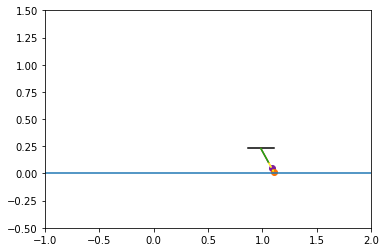

In [19]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[2]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [20]:
print(results.solver.termination_condition) # check if optimal

optimal


In [21]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

102

In [22]:
vel = 0.0

for n in range(1,N+1):
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footR'].value)
    #print(m.tau_torque[n,'left'].value)
    pass

print(m.q[N,'x_body'].value)
vel/TT

0.985600004924566


0.0

In [23]:
tau_sum_value = 0.0
pen_sum_value = 0.0
transport_sum_value = 0.0

for n in range(1,N+1):

        for side in sides:
            tau_sum_value += (m.tau_torque[n,'+ve',side].value-m.tau_torque[n,'-ve',side].value)**2 
        transport_sum_value += ((m.tau_torque[n,'+ve','right'].value-m.tau_torque[n,'-ve','right'].value + m.tau_torque[n,'+ve','left'].value-m.tau_torque[n,'-ve','left'].value)**2)/(m.q[N,'x_body'].value)

        for gc in ground_constraints:
            for foot in feet:
                pen_sum_value += m.ground_penalty[n,gc,foot].value 
                
print(pen_sum_value*(10**4))
print(transport_sum_value)

KeyError: "Index '(1, '+ve', 'left')' is not valid for indexed component 'tau_torque'"

In [ ]:
print(results.solver.termination_condition) # check if optimal

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step (select motion)'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

In [ ]:
m.mu.value